https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost

# Objective  
새로운 유저의 첫 번째 여행 목적지를 예측하는 모델



*   Data
  *   id: user id
  *   date_account_created: 계정 생성일
  *   timestamp_first_active: 첫 번재 활동 시간
  *   date_first_booking: 첫 번째 예약 날짜
  *   gender: 성별
  *   age: 나이
  *   signup_method: 회원 가입 방법, 여부
  *   signup_flow: 등록하러 온 경로
  *   language: 언어
  *   affiliate_channel: 마케팅 종류
  *   affiliate_provider: 마케팅 제공사
  *   first_affiliate_tracked: 처음으로 사용한 마케팅
  *   signup_app: 앱 가입 여부 
  *   first_device_type: 
  *   first_browser: 
  *   country_destination: target variable로 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other' 가 있음. 'NDF'는 예약 안함을 의미




In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hhs1516","key":"df77d1870d62b8065b1ea188acc8273c"}'}

In [2]:
ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
#!kaggle competitions list

In [4]:
!kaggle competitions download -c airbnb-recruiting-new-user-bookings

 76% 45.0M/59.1M [00:00<00:00, 39.3MB/s]
100% 59.1M/59.1M [00:00<00:00, 81.1MB/s]
  0% 0.00/478k [00:00<?, ?B/s]
100% 478k/478k [00:00<00:00, 149MB/s]
  0% 0.00/4.07M [00:00<?, ?B/s]
100% 4.07M/4.07M [00:00<00:00, 66.4MB/s]
  0% 0.00/546 [00:00<?, ?B/s]
100% 546/546 [00:00<00:00, 517kB/s]
  0% 0.00/1.03M [00:00<?, ?B/s]
100% 1.03M/1.03M [00:00<00:00, 150MB/s]
  0% 0.00/2.46k [00:00<?, ?B/s]
100% 2.46k/2.46k [00:00<00:00, 2.50MB/s]


In [5]:
!unzip -n /content/age_gender_bkts.csv.zip
!unzip -n /content/countries.csv.zip
!unzip -n /content/sample_submission_NDF.csv.zip
!unzip -n /content/sessions.csv.zip
!unzip -n /content/test_users.csv.zip
!unzip -n /content/train_users_2.csv.zip

Archive:  /content/age_gender_bkts.csv.zip
  inflating: age_gender_bkts.csv     
Archive:  /content/countries.csv.zip
  inflating: countries.csv           
Archive:  /content/sample_submission_NDF.csv.zip
  inflating: sample_submission_NDF.csv  
Archive:  /content/sessions.csv.zip
  inflating: sessions.csv            
Archive:  /content/test_users.csv.zip
  inflating: test_users.csv          
Archive:  /content/train_users_2.csv.zip
  inflating: train_users_2.csv       


In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings("ignore")
age_gender_bkts = pd.read_csv("/content/age_gender_bkts.csv")
countries = pd.read_csv("/content/countries.csv")
sample_submission_NDF = pd.read_csv("/content/sample_submission_NDF.csv")
sessions = pd.read_csv("/content/sessions.csv")
test_users = pd.read_csv("/content/test_users.csv")
train_users_2 = pd.read_csv("/content/train_users_2.csv")

In [7]:
df_train = train_users_2
df_test = test_users

EDA를 위한 train-test concat  
? train test따로 EDA하는건?

In [8]:
labels = df_train.country_destination.values
id_test = df_test.id
df_train.drop(['country_destination'], axis = 1)
#Concatenating train and test data for EDA
df_all = pd.concat((df_train, df_test), axis = 0, ignore_index= True)

In [9]:
df_all.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [58]:
feats = ['signup_method', 'signup_flow', 'language', 'affiliate_channel',
         'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

dic = {}
for x in feats:
  dic[x] = list(df_all[x].unique())
  print(x + ': ',end = '')
  print(dic[x])

signup_method: ['facebook', 'basic', 'google', 'weibo']
signup_flow: [0, 3, 2, 1, 24, 8, 6, 5, 10, 25, 12, 4, 16, 15, 20, 21, 23, 14]
language: ['en', 'fr', 'de', 'es', 'it', 'pt', 'zh', 'ko', 'ja', 'ru', 'pl', 'el', 'sv', 'nl', 'hu', 'da', 'id', 'fi', 'no', 'tr', 'th', 'cs', 'hr', 'ca', 'is', '-unknown-']
affiliate_channel: ['direct', 'seo', 'other', 'sem-non-brand', 'content', 'sem-brand', 'remarketing', 'api']
affiliate_provider: ['direct', 'google', 'other', 'craigslist', 'facebook', 'vast', 'bing', 'meetup', 'facebook-open-graph', 'email-marketing', 'yahoo', 'padmapper', 'gsp', 'wayn', 'naver', 'baidu', 'yandex', 'daum']
first_affiliate_tracked: ['untracked', 'omg', nan, 'linked', 'tracked-other', 'product', 'marketing', 'local ops']
signup_app: ['Web', 'Moweb', 'iOS', 'Android']
first_device_type: ['Mac Desktop', 'Windows Desktop', 'iPhone', 'Other/Unknown', 'Desktop (Other)', 'Android Tablet', 'iPad', 'Android Phone', 'SmartPhone (Other)']
first_browser: ['Chrome', 'IE', 'Firefo

In [10]:
def print_null(df_all):
  for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
      print(i + ' has {} null values.'.format(ab)+'\n')

print_null(df_all)

date_first_booking has 186639 null values.

age has 116866 null values.

first_affiliate_tracked has 6085 null values.

country_destination has 62096 null values.



In [11]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   date_account_created     275547 non-null  object 
 2   timestamp_first_active   275547 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   275547 non-null  object 
 5   age                      158681 non-null  float64
 6   signup_method            275547 non-null  object 
 7   signup_flow              275547 non-null  int64  
 8   language                 275547 non-null  object 
 9   affiliate_channel        275547 non-null  object 
 10  affiliate_provider       275547 non-null  object 
 11  first_affiliate_tracked  269462 non-null  object 
 12  signup_app               275547 non-null  object 
 13  first_device_type        275547 non-null  object 
 14  firs

In [12]:
df_all = df_all.drop(['id','country_destination','date_first_booking'], axis =1)

In [13]:
print_null(df_all)

age has 116866 null values.

first_affiliate_tracked has 6085 null values.



In [14]:
df_all.head()

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [15]:
df_all.gender.value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

In [16]:
df_all.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

age<15 , age>=100 을 nan으로

In [17]:
df_all[df_all['age']<15].age = np.nan
df_all[df_all['age']>=100].age = np.nan

str type 보다 category type 사용하는 이유는 메모리가 절약되기 때문이라고 한다.

In [18]:
#Converting below columns as categories for plotting in graphs
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

for categorical_feature in categorical_features:
    df_all[categorical_feature] = df_all[categorical_feature].astype('category')

str -> datetime

In [19]:
df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'])
df_all['timestamp_first_active'] = pd.to_datetime(df_all['timestamp_first_active'], format='%Y%m%d%H%M%S')

In [20]:
type(df_all['date_account_created'].iloc[2])

pandas._libs.tslibs.timestamps.Timestamp

# Visualizations

In [21]:
sns.set_style('whitegrid')
sns.set_context("talk")

아래 그림에서 gender가 약 반이 unknown으로 나옴을 확인할 수 있다

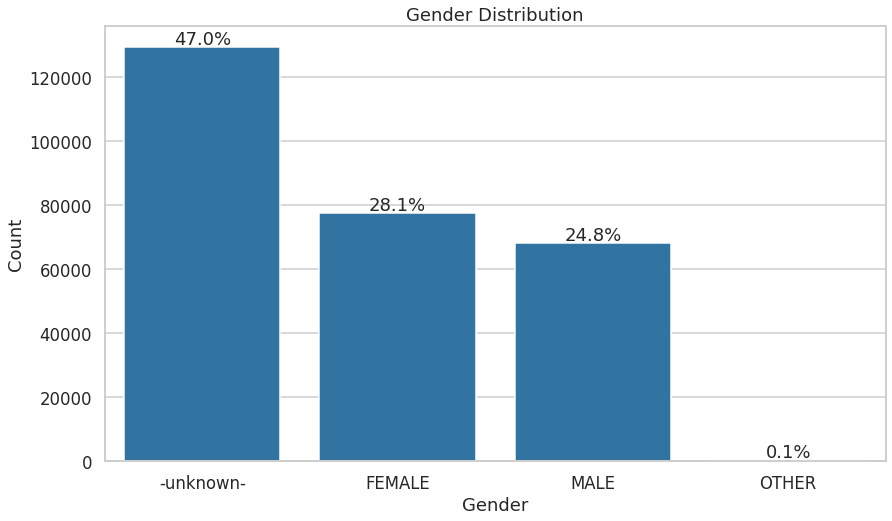

In [22]:
plt.figure(figsize=(14,8))
order1 = df_all['gender'].value_counts().index
sns.countplot(data = df_all, x = 'gender', order = order1, color = sns.color_palette()[0])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
order2 = df_all['gender'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_all.shape[0])
    plt.text(i,count+1000,strt,ha='center')

train data 의 country_destination을 시각화하여 본 결과 NDF가 가장 많음을 보였다.

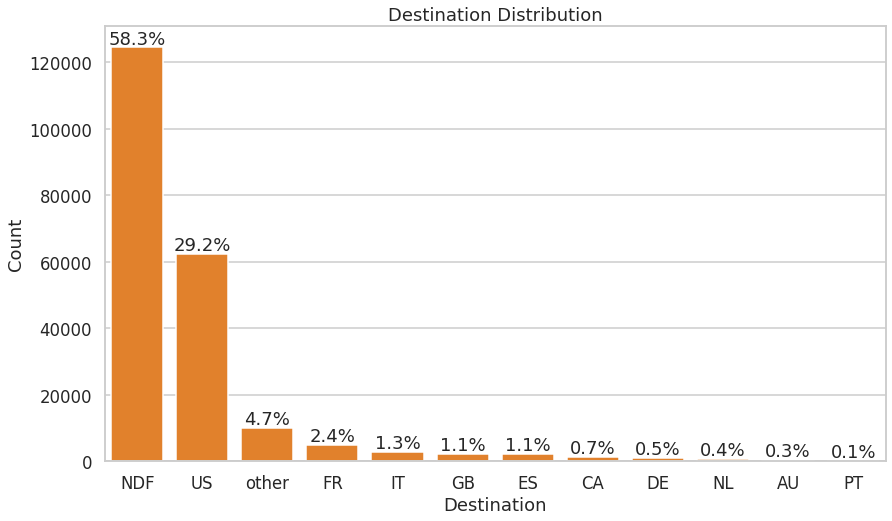

In [23]:
plt.figure(figsize=(14,8))
order1 = df_train['country_destination'].value_counts().index
sns.countplot(data = df_train, x = 'country_destination', order = order1, color = sns.color_palette()[1])
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Destination Distribution')
order2 = df_train['country_destination'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_train.shape[0])
    plt.text(i,count+1000,strt,ha='center')

In [24]:
#Extracting year for date_account_created
df_all['acc_year'] = df_all['date_account_created'].dt.year


df1 = df_all.groupby('acc_year').count()
df1.head()

years = [2010,2011,2012,2013,2014]
yearsOrder=pd.api.types.CategoricalDtype(ordered=True, categories=years)
df1.reset_index(inplace = True)
df1.acc_year = df1.acc_year.astype(yearsOrder)

date_account_created 에서는 2014년도에 계정이 많이 생성됨을 확인할 수 있고, 그에 따라 2014년의 월단위로 분포를 확인한다.

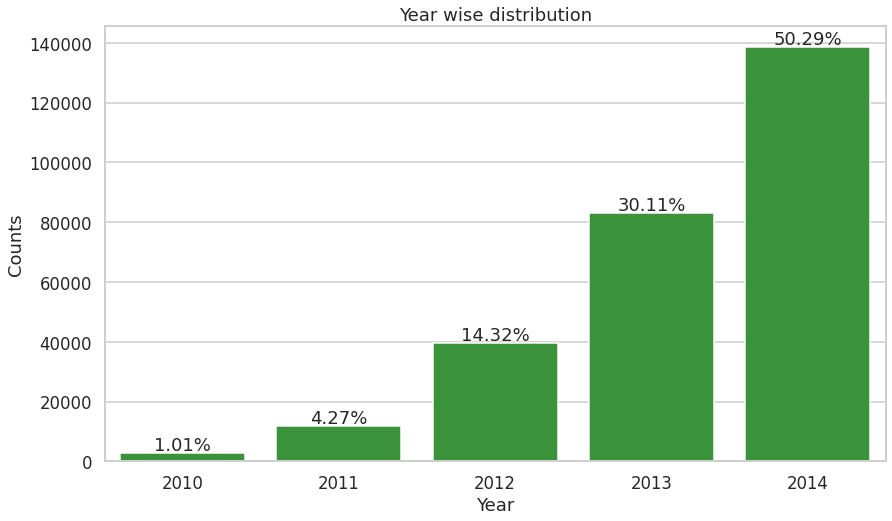

In [25]:
plt.figure(figsize=[14,8])
sns.barplot(data=df1,x='acc_year',y='affiliate_provider',color=sns.color_palette()[2]);
plt.title('Year wise distribution');
plt.xlabel('Year')
plt.ylabel('Counts')
for i in range(df1.shape[0]):
    count=df1.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+1000,strt,ha='center')

In [26]:
df2 = df_all[df_all['date_account_created'].dt.year==2014]
df2['monthYear14'] = df2['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df2 = df2.groupby('monthYear14').count()

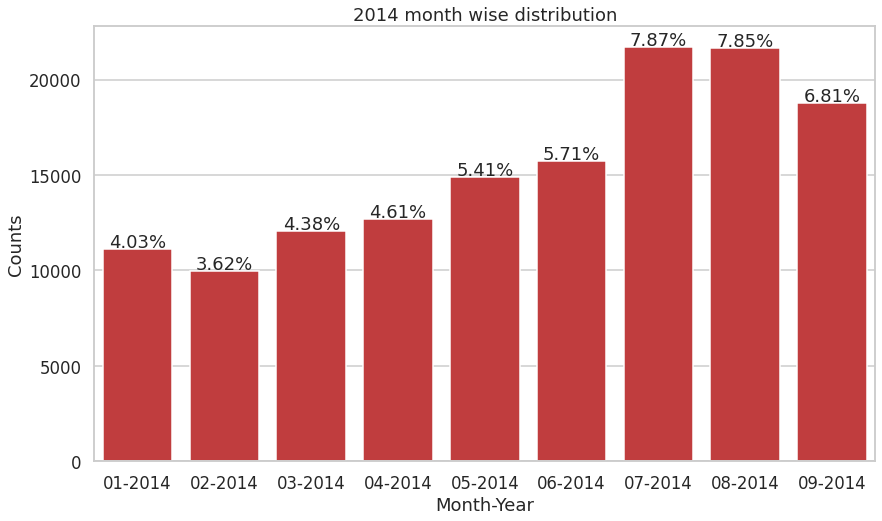

In [27]:
plt.figure(figsize=[14,8])
sns.barplot(data=df2,x=df2.index,y='affiliate_provider',color=sns.color_palette()[3]);
plt.title('2014 month wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')
for i in range(df2.shape[0]):
    count=df2.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+100,strt,ha='center')

2014년과 비교하기 위해 2013년도도 시각화 하였는데, 2014년엔 9월까지 있음을 보아 이 데이터셋은 2014년 9월까지의 데이터셋임을 알 수 있다.

In [28]:
df3 = df_all[df_all['date_account_created'].dt.year==2013]
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df3 = df3.groupby('monthYear13').count()

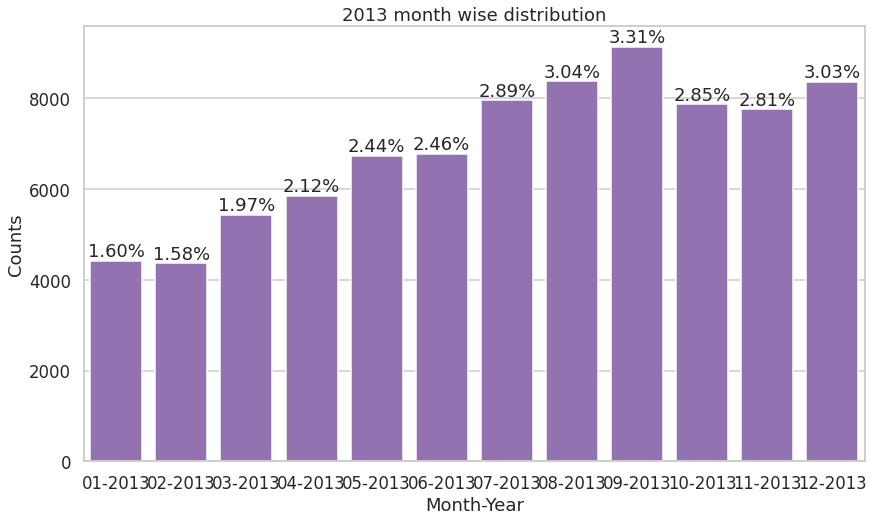

In [29]:
plt.figure(figsize=[14,8])
sns.barplot(data=df3,x=df3.index,y='affiliate_provider',color=sns.color_palette()[4]);
plt.title('2013 month wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')
for i in range(df3.shape[0]):
    count=df3.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+100,strt,ha='center')

이는 유저들의 age를 categorical하게 변환시킨 column을 추가한다.

In [30]:
df_all['member_age_bins']=df_all['age'].apply(lambda x: '18 - 20' if 18<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else '60-70' if 60<x<=70
                                                  else '70+' if 70<x<=100
                                                  else np.nan)

유저들의 연령층을 확인한 결과, 30\~40세가 가장많고 20\~30,40\~50이 두번째로 같게 확인할 수 있다.

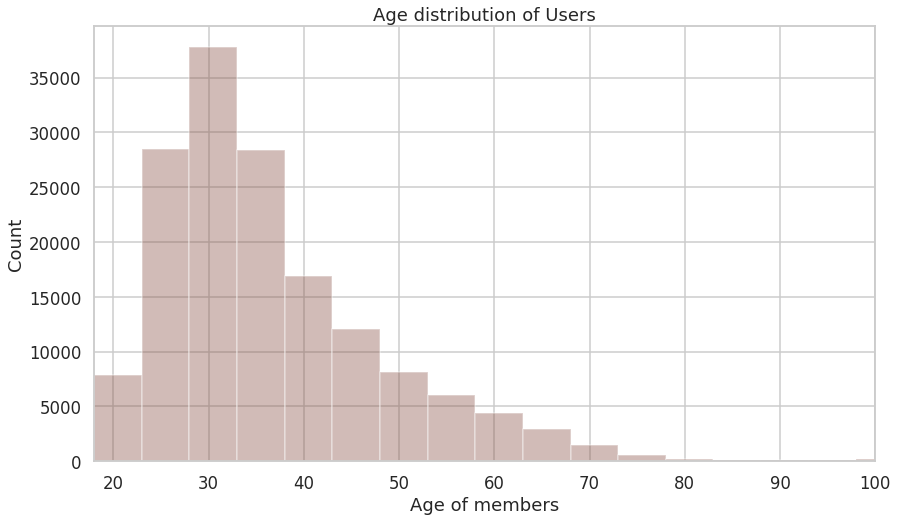

In [31]:
plt.figure(figsize=[14,8])
sns.distplot(df_all.age.dropna(),bins=np.arange(18,100+5,5),color=sns.color_palette()[5],kde=False);
plt.xlabel('Age of members')
plt.ylabel('Count')
plt.title('Age distribution of Users')
plt.xlim(18,100);

이는 도시별 연령층 분포를 box plot으로 시각화한 것이다.

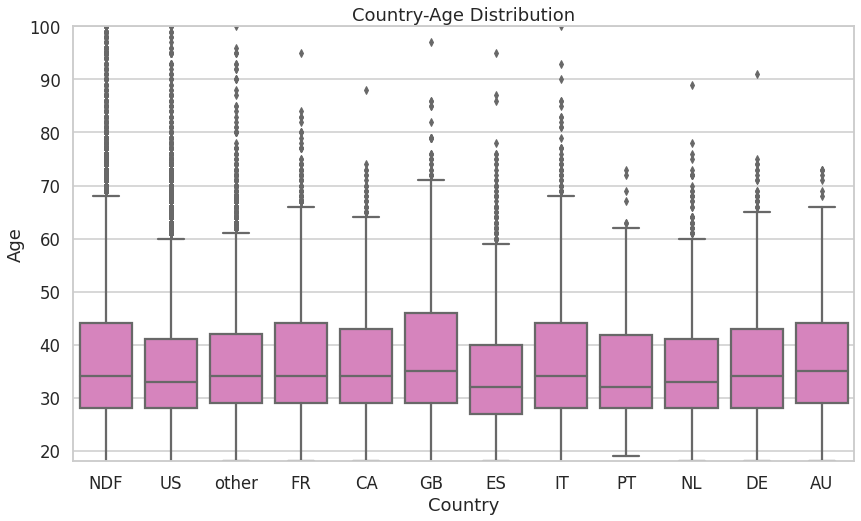

In [32]:
plt.figure(figsize=[14,8])
sns.boxplot(data=df_train,y='age',x='country_destination',color=sns.color_palette()[6]);
plt.ylim(18,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country-Age Distribution');

나이별 연령 분포 boxplot 시각화

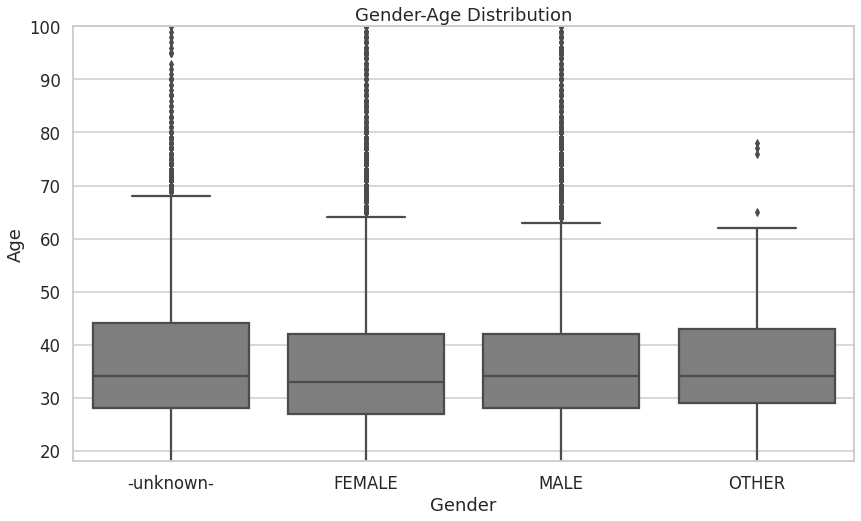

In [33]:
plt.figure(figsize=[14,8])
sns.boxplot(data=df_all,y='age',x='gender',color=sns.color_palette()[7]);
plt.ylim(18,100)
plt.xlabel('Gender');
plt.ylabel('Age');
plt.title('Gender-Age Distribution');

도시별 성별 분포

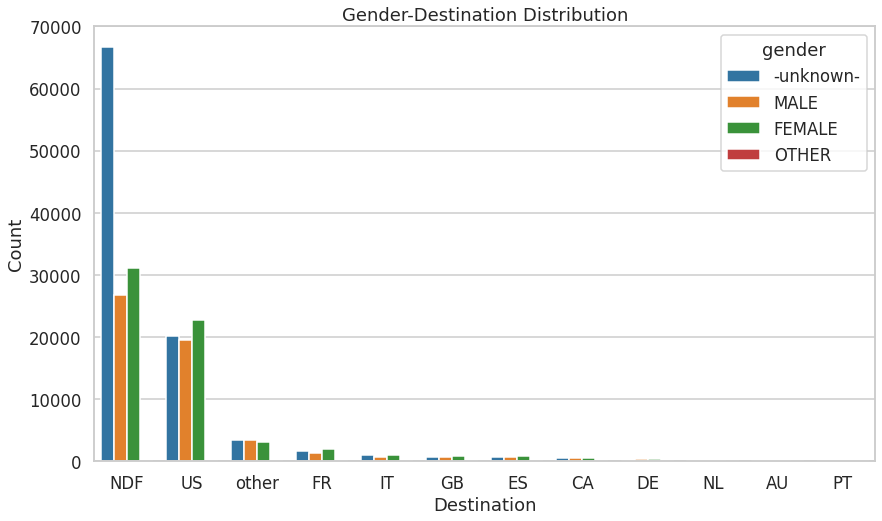

In [34]:
plt.figure(figsize=(14,8))
order1 = df_train['country_destination'].value_counts().index
sns.countplot(data = df_train, x = 'country_destination', order = order1,hue='gender')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Gender-Destination Distribution')
order2 = df_train['country_destination'].value_counts()

2013년의 월별 연령 분포

In [35]:
df3 = df_all[df_all['date_account_created'].dt.year==2013]
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))

df3= df3.groupby(['monthYear13','member_age_bins']).count()

df3.reset_index(inplace=True)

Text(0, 0.5, 'Counts')

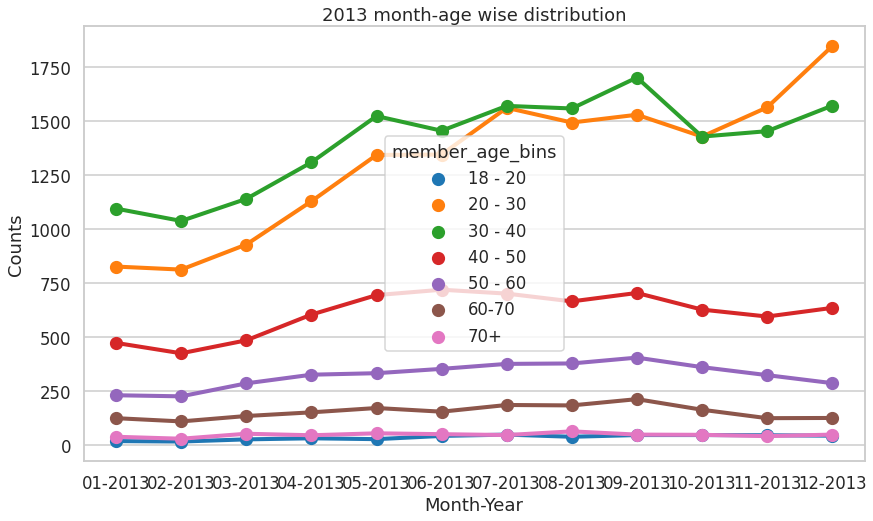

In [36]:
plt.figure(figsize=[14,8])
sns.pointplot(data=df3,x='monthYear13',y='affiliate_provider',hue='member_age_bins');
plt.title('2013 month-age wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

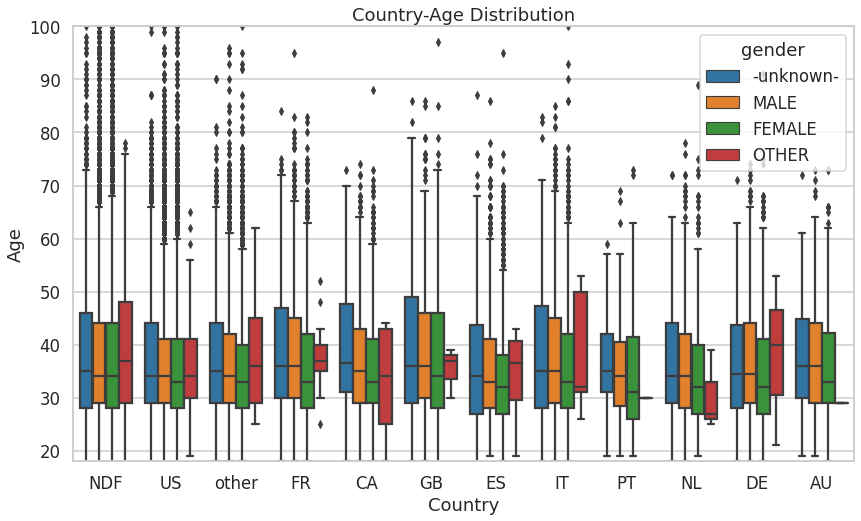

In [37]:
plt.figure(figsize=[14,8])
sns.boxplot(data=df_train,y='age',x='country_destination',hue='gender');
plt.ylim(18,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country-Age Distribution');

위의 시각화를 통해 gender == unknown과 train에서의 NDF값은 상관관계가 있음을 추론할 수 있었다. 이와 비슷한 느낌으로 gender == unknown, age >= 100 or age == nan 과도 상관 관계가 있을 것이라 생각할 수 있다.

Computation for the Booking Destination

In [38]:
df_train = df_train.drop(['country_destination'], axis = 1)

In [39]:
dfWork = pd.concat((df_train, df_test), axis=0, ignore_index=True)
dfWork = dfWork.drop(['id', 'date_first_booking'], axis=1)

dfWork = dfWork.fillna(-1) # filling nan to -1

In [40]:
dac = np.vstack(dfWork.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
dfWork['dac_year'] = dac[:,0]
dfWork['dac_month'] = dac[:,1]
dfWork['dac_day'] = dac[:,2]
dfWork = dfWork.drop(['date_account_created'], axis=1)

In [41]:
dfWork['timestamp_first_active']

0         20090319043255
1         20090523174809
2         20090609231247
3         20091031060129
4         20091208061105
               ...      
275542    20140930235232
275543    20140930235306
275544    20140930235408
275545    20140930235430
275546    20140930235901
Name: timestamp_first_active, Length: 275547, dtype: int64

In [42]:
tfa = np.vstack(dfWork.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
dfWork['tfa_year'] = tfa[:,0]
dfWork['tfa_month'] = tfa[:,1]
dfWork['tfa_day'] = tfa[:,2]
dfWork = dfWork.drop(['timestamp_first_active'], axis=1)

age < 14 or age > 100 일때 -1로 치환

In [43]:
av = dfWork.age.values
dfWork['age'] = np.where(np.logical_or(av<14, av>100), -1, av)

One hot Encoding

In [44]:
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel',
             'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
  dfWork_dummy = pd.get_dummies(dfWork[f], prefix=f) # prefix는 변수명이 f_1 , f_2
  dfWork = dfWork.drop([f], axis=1) # f drop
  dfWork = pd.concat((dfWork, dfWork_dummy), axis=1) # dummy concat

train test split  
[LabelEncoder 참고](https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221592651246&proxyReferer=https:%2F%2Fwww.google.com%2F)

In [45]:
len(labels)

213451

In [46]:
vals = dfWork.values
X = vals[:df_train.shape[0]] # train slice
le = LabelEncoder()
y = le.fit_transform(labels)  # one hot encoding
X_test = vals[df_train.shape[0]:]

# XGBoost  
max_depth: 트리의 깊이 수  
learning_rate: 학습률  
n_estimaors: 생성할 weak learner 수  
objective: 목적함수 multi:softprob은 다중분류, 확률 반환  
subsample: data중 sampling  
colsample_bytrees: column 중 sampling  


In [59]:
xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytrees=0.5, seed=0)
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, colsample_bytrees=0.5,
              gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=25, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.5, verbosity=1)

<function matplotlib.pyplot.show>

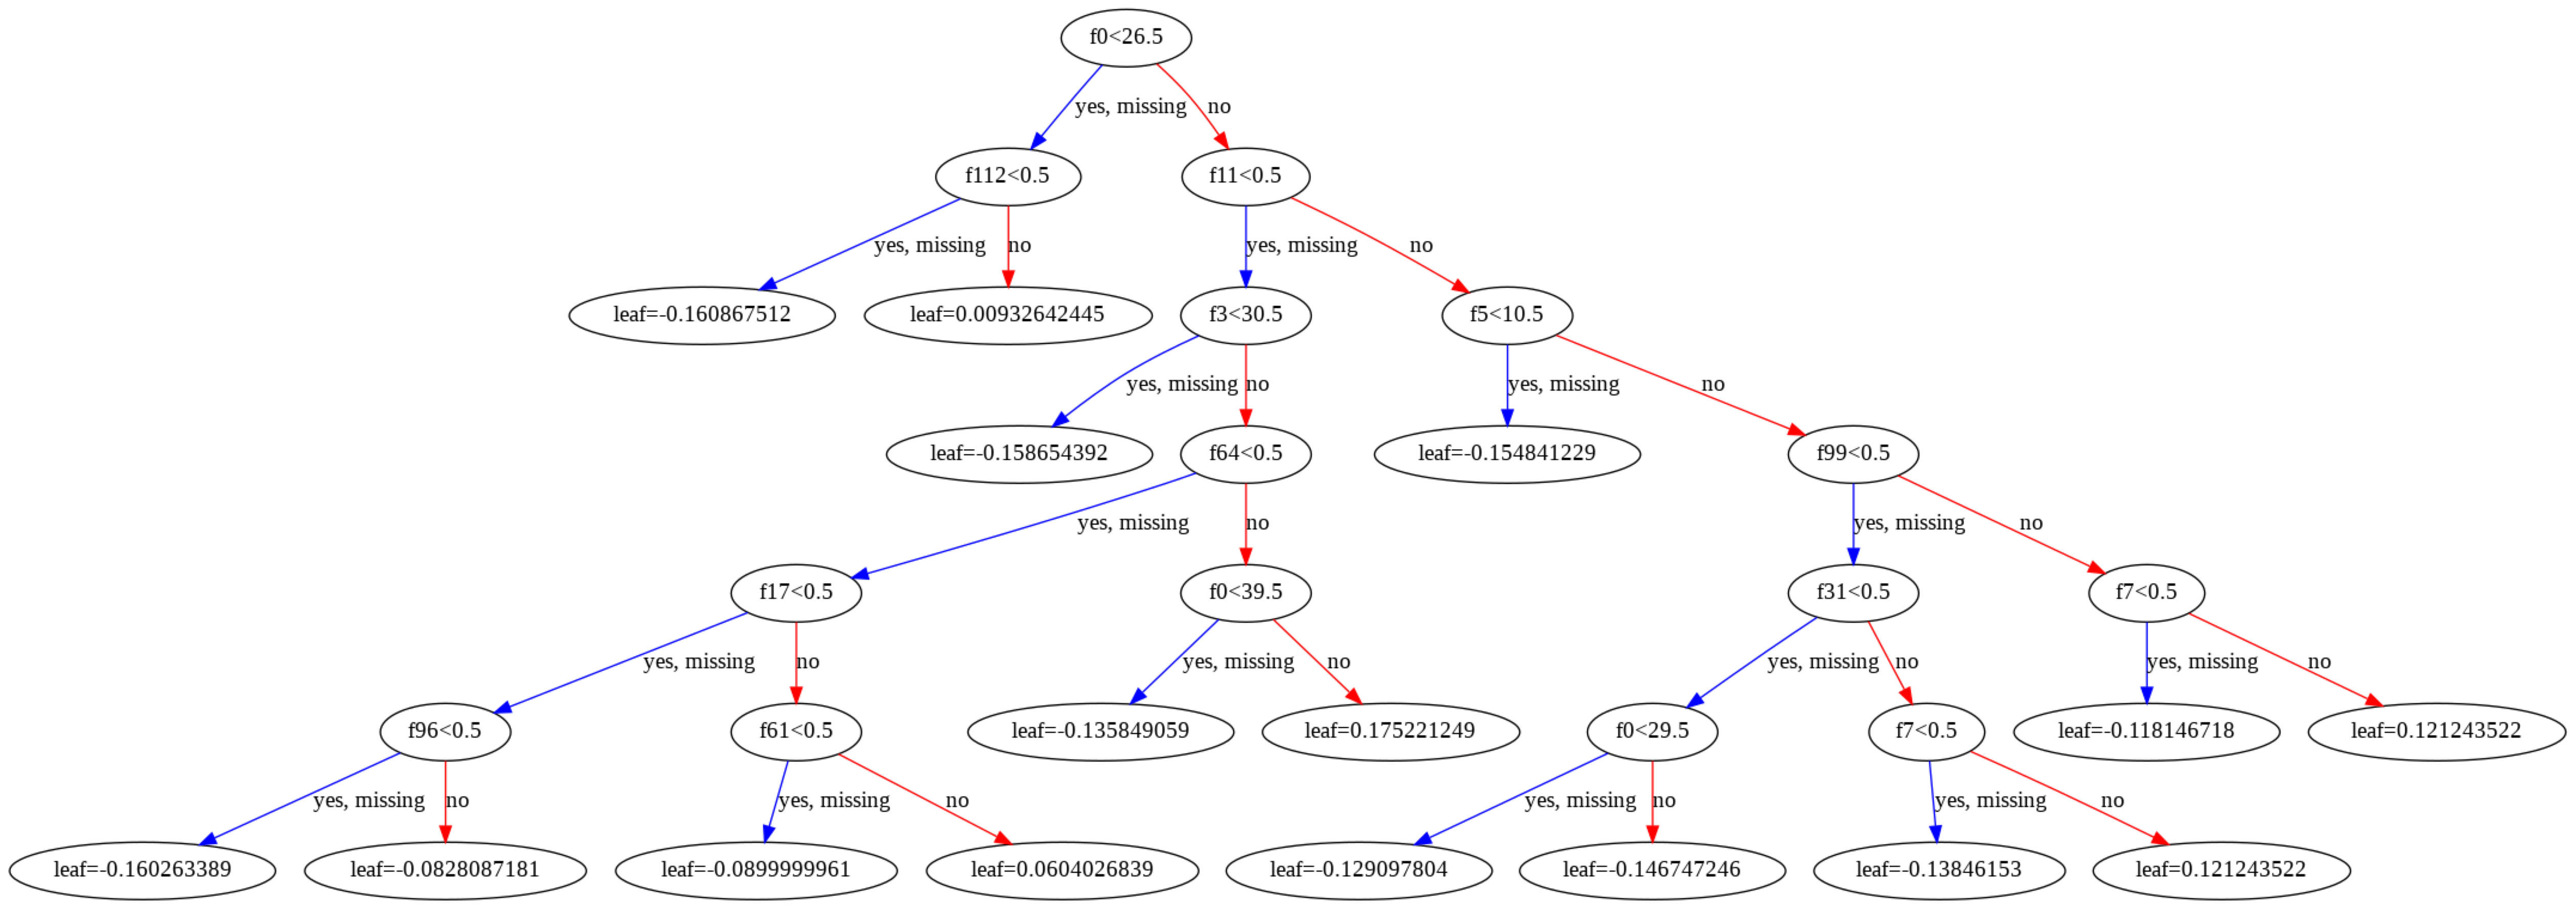

In [60]:
from xgboost import plot_tree
plot_tree(xgb)
fig = plt.gcf()
fig.set_size_inches(90,60)
plt.show

In [61]:
y_pred = xgb.predict_proba(X_test)

In [62]:
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [ ]:
len(cts)

In [ ]:
sample_submission_NDF



---

